# Training a classifier

## Imports

In [35]:
import torch
import torchvision
import torchvision.transforms as transforms

## 1. Load and Normalizing the data

In [36]:
transform = transforms.Compose([
    transforms.ToTensor()
    ,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

trainset = torchvision.datasets.CIFAR10(
    root = './data'
    , train = True
    , download = True
    , transform = transform
)

trainloader = torch.utils.data.DataLoader(
    dataset = trainset
    , batch_size = 4
    , shuffle = True
    , num_workers = 2
)

testset = torchvision.datasets.CIFAR10(
    root = './data'
    , train = False
    , download = True
    , transform = transform
)

testloader = torch.utils.data.DataLoader(
    dataset = testset
    , batch_size = 4
    , shuffle = False
    , num_workers = 2
)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## 2. Data exploration

plane  ship  bird truck


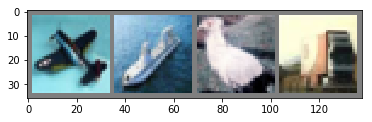

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# function to show an image

def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy() 
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 3. Bulding a convolutional  NN

In [41]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net().cuda()

print(torch.cuda.is_available())

True


## 4. Define loss function

In [42]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

## 5. Train the NN

In [43]:
from datetime import datetime
start = datetime.now()

for epoch in range(2):
    running_loss = 0.0
    for i, data in  enumerate(trainloader, 0):
        # get the input
        inputs, labels = data
        
        # wrap them in variable
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, running_loss / 2000)
                 )
            running_loss = 0

            
finish = datetime.now()
elapsed = finish - start
print('Finished Training in: ' + str(elapsed))
        
    

[1,  2000] loss: 2.188
[1,  4000] loss: 1.812
[1,  6000] loss: 1.636
[1,  8000] loss: 1.561
[1, 10000] loss: 1.487
[1, 12000] loss: 1.461
[2,  2000] loss: 1.393
[2,  4000] loss: 1.370
[2,  6000] loss: 1.346
[2,  8000] loss: 1.324
[2, 10000] loss: 1.287
[2, 12000] loss: 1.297
Finished Training in: 0:00:49.683524


## 6. Check results 

### a) Ground thruth

Ground Thruth:    cat  ship  ship plane


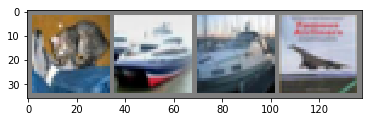

In [45]:
dataiter = iter(testloader)
images, labels = dataiter.next()

#print images
imshow(torchvision.utils.make_grid(images))
print('Ground Thruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

### b) Predictions

In [46]:
outputs = net(Variable(images.cuda()))

# get highest score per image
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Predicted:    cat  ship  ship plane


### c) Evaluation

In [47]:
correct = 0
total = 0

for data in testloader:
    images, labels = data
    outputs = net(Variable(images.cuda()))
    _, predicted = torch.max(outputs.data.cpu(), 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
    

Accuracy of the network on the 10000 test images: 56 %


In [48]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images.cuda()))
    _, predicted = torch.max(outputs.data.cpu(), 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1
        
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 54 %
Accuracy of   car : 76 %
Accuracy of  bird : 48 %
Accuracy of   cat : 40 %
Accuracy of  deer : 44 %
Accuracy of   dog : 46 %
Accuracy of  frog : 69 %
Accuracy of horse : 62 %
Accuracy of  ship : 76 %
Accuracy of truck : 49 %


## 7. Conclusion

Make sure a cuda() tensor is moved back to host cpu with ´.cpu()´ command before trying to visualise it